# Using Simple Linear Regression to Predict Total Amount and Tip Rate

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
    './new-york-data-analysis-LT-b3f6a483fa4b.json')
project_id = 'new-york-data-analysis-lt'
client = bigquery.Client(credentials= credentials,project=project_id)

### Getting random 1,000,000 million rows of cleaned data

In [37]:
query_job = client.query("""
  WITH t2 AS
(
SELECT 
    t.*,
    tz_pu.zone_id as pickup_zone_id,
    tz_pu.zone_name as pickup_zone_name,
    tz_pu.borough as pickup_borough,
    tz_do.zone_id as dropoff_zone_id,
    tz_do.zone_name as dropoff_zone_name,
    tz_do.borough as dropoff_borough,
    CONCAT(tz_pu.borough,"-",tz_do.borough) as route_borough,
    CONCAT(tz_pu.zone_name,"-",tz_do.zone_name) as route_zone_name
FROM
(
SELECT *,
    TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) as time_duration_in_secs,
    ROUND(trip_distance/TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND),2)*3600 as driving_speed_miles_per_hour,
    (CASE WHEN total_amount=0 THEN 0
    ELSE ROUND(tip_amount*100/total_amount,2) END) as tip_rate,
    EXTRACT(YEAR from pickup_datetime) as pickup_year,
    EXTRACT(MONTH from pickup_datetime) as pickup_month,
    CONCAT(CAST(EXTRACT(YEAR from pickup_datetime) as STRING),"-",CAST(EXTRACT(MONTH from pickup_datetime) AS STRING)) as pickup_yearmonth,
    EXTRACT(DATE from pickup_datetime) as pickup_date,
    FORMAT_DATE('%A',DATE(pickup_datetime)) as pickup_weekday_name,
    EXTRACT(HOUR from pickup_datetime) as pickup_hour,
    EXTRACT(YEAR from dropoff_datetime) as dropoff_year,
    EXTRACT(MONTH from dropoff_datetime) as dropoff_month,
    CONCAT(CAST(EXTRACT(YEAR from dropoff_datetime) as STRING),"-",CAST(EXTRACT(MONTH from dropoff_datetime) AS STRING)) as dropoff_yearmonth,
    EXTRACT(DATE from dropoff_datetime) as dropoff_date,
    FORMAT_DATE('%A',DATE(dropoff_datetime)) as dropoff_weekday_name,
    EXTRACT(HOUR from dropoff_datetime) as dropoff_hour
    
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
/* filter by latitude & longitude that are within the correct range */
WHERE 
  ((pickup_latitude BETWEEN -90 AND 90) AND
  (pickup_longitude BETWEEN -180 AND 180)) 
AND
  ((dropoff_latitude BETWEEN -90 AND 90) AND
  (dropoff_longitude BETWEEN -180 AND 180))
) t
/* find the boroughs and zone names for dropoff locations */
INNER JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` tz_do ON 
(ST_DWithin(tz_do.zone_geom,ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0))
/* find the boroughs and zone names for pickup locations */
INNER JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` tz_pu ON 
(ST_DWithin(tz_pu.zone_geom,ST_GeogPoint(pickup_longitude, pickup_latitude), 0))
WHERE 
    pickup_datetime BETWEEN '2016-01-01' AND '2016-12-31' 
    AND dropoff_datetime BETWEEN '2016-01-01' AND '2016-12-31'
    AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) > 0
    AND passenger_count > 0
    AND trip_distance >= 0 
    AND tip_amount >= 0 
    AND tolls_amount >= 0 
    AND mta_tax >= 0 
    AND fare_amount >= 0
    AND total_amount >= 0
)


SELECT
pickup_datetime,dropoff_datetime,passenger_count,trip_distance,
pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,
rate_code,payment_type,total_amount,tip_amount,time_duration_in_secs,tip_rate,
pickup_weekday_name,pickup_hour,pickup_borough,pickup_zone_id,dropoff_borough,dropoff_zone_id

FROM
t2
ORDER BY RAND()
LIMIT 1000000
  
  """)
results = query_job.result()


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
df=results.to_dataframe()

In [40]:
data=df.copy()

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 22085
Data columns (total 20 columns):
pickup_datetime          1000000 non-null datetime64[ns, UTC]
dropoff_datetime         1000000 non-null datetime64[ns, UTC]
passenger_count          1000000 non-null int64
trip_distance            1000000 non-null float64
pickup_longitude         1000000 non-null float64
pickup_latitude          1000000 non-null float64
dropoff_longitude        1000000 non-null float64
dropoff_latitude         1000000 non-null float64
rate_code                1000000 non-null int64
payment_type             1000000 non-null object
total_amount             1000000 non-null float64
tip_amount               1000000 non-null float64
time_duration_in_secs    1000000 non-null int64
tip_rate                 1000000 non-null float64
pickup_weekday_name      1000000 non-null object
pickup_hour              1000000 non-null int64
pickup_borough           1000000 non-null object
pickup_zone_id           1

### Remove outliers
Some trip_distance and time_duration_in_secs values are extremely large. I will remove these obvious outliers from the dataset.

In [47]:
#remove outliers
data=data[data.trip_distance<=100000]
data=data[data.time_duration_in_secs<=100000]

## Scatter plot showing relationship between trip distance and total amount
The Pearson's correlation of trip_distance and total_amount is 0.92, showing a strong correlation between these two variables.

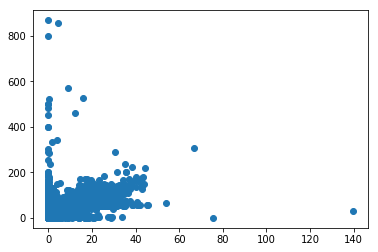

In [49]:
plt.scatter(data.trip_distance,data.total_amount)

In [52]:
from scipy import stats
stats.pearsonr(data.trip_distance,data.total_amount)

(0.9214358760818963, 0.0)

## Scatter plot showing relationship between time_duration_in_secs and total amount
The plot does not show strong correlation between trip duration and total amount

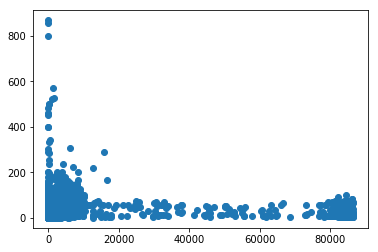

In [54]:
plt.scatter(data.time_duration_in_secs,data.total_amount)

In [55]:
stats.pearsonr(data.time_duration_in_secs,data.total_amount)

(0.16701985906979622, 0.0)

### Predicting total amount: Linear Regression

In [60]:
#columns that will be used for the prediction
use_columns=['passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'rate_code', 'payment_type',
       'time_duration_in_secs','pickup_weekday_name', 'pickup_hour', 'pickup_borough',
       'dropoff_borough','total_amount']
data_2=data[use_columns].copy()

#categorical columns that need to be one-hot-encoded
one_hot_columns=['rate_code','payment_type','pickup_weekday_name','pickup_hour',
                'pickup_borough','dropoff_borough']

#one-hot encoding
data_2=pd.get_dummies(data=data_2,columns=one_hot_columns)

#columns to drop after one-hot encoding to avoid dummy variable trap
columns_to_drop_after_onehot=['rate_code_1','payment_type_1','pickup_weekday_name_Monday',
                         'pickup_hour_0','pickup_borough_Bronx','dropoff_borough_Bronx']

#drop columns to avoid dummy variable trap
data_2.drop(columns_to_drop_after_onehot,axis=1,inplace=True)

#remove total_amount column
X=data_2.drop(['total_amount'],axis=1).values

#target column is total_amount
y=data_2['total_amount'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)

from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(X_train,y_train)

y_pred=regressor.predict(X_test)
print("Prediction\n",y_pred)
print("Actual\n",y_test)

print("R_squared Score:",regressor.score(X_test,y_test))

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test,y_pred)
print("MAE:",mae)

from sklearn.metrics import mean_squared_error
print("RMSE:",mean_squared_error(y_test,y_pred)**0.5)

Prediction
 [10.83824432 16.26999609 11.60741989 ... 16.16553833 16.13452438
 14.74041533]
Actual
 [11.15 22.56 10.3  ... 20.75 20.16 13.3 ]
R_squared Score: 0.8938700850000085
MAE: 2.174270866877639
RMSE: 4.198184002254333


In [64]:
print("Range of total amount:", (data_2.total_amount.min(),data_2.total_amount.max()))

Range of total amount: (0.0, 867.3)


### Predicting tip rate: Linear Regression

In [80]:
#columns that will be used for the prediction
use_columns=['passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'rate_code', 'payment_type',
       'time_duration_in_secs','pickup_weekday_name', 'pickup_hour', 'pickup_borough',
       'dropoff_borough','tip_rate']
data_2=data[use_columns].copy()

#categorical columns that need to be one-hot-encoded
one_hot_columns=['rate_code','payment_type','pickup_weekday_name','pickup_hour',
                'pickup_borough','dropoff_borough']

#one-hot encoding
data_2=pd.get_dummies(data=data_2,columns=one_hot_columns)

#columns to drop after one-hot encoding to avoid dummy variable trap
columns_to_drop_after_onehot=['rate_code_1','payment_type_1','pickup_weekday_name_Monday',
                         'pickup_hour_0','pickup_borough_Bronx','dropoff_borough_Bronx']

#drop columns to avoid dummy variable trap
data_2.drop(columns_to_drop_after_onehot,axis=1,inplace=True)

#remove total_amount column
X=data_2.drop(['tip_rate'],axis=1).values

#target column is total_amount
y=data_2['tip_rate'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)

from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(X_train,y_train)

y_pred=regressor.predict(X_test)
print("Prediction\n",y_pred)
print("Actual\n",y_test)

print("R_squared Score:",regressor.score(X_test,y_test))

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test,y_pred)
print("MAE:",mae)

from sklearn.metrics import mean_squared_error
print("RMSE:",mean_squared_error(y_test,y_pred)**0.5)

Prediction
 [15.50282892 15.50074233 15.62410857 ... 15.60428409 15.57719728
 -0.16544059]
Actual
 [16.59 16.67  9.71 ... 16.63 16.67  0.  ]
R_squared Score: 0.7440795292705931
MAE: 2.4103793168303294
RMSE: 4.271338805126146
